# Person Re-ID with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.datasets.reid import TripletDataGenerator, TestingDataGenerator
from vbranch.applications.resnet import ResNet50
from vbranch.callbacks import reid_acc
from vbranch.losses import triplet

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data_iterator_from_generator, lr_exp_decay_scheduler

In [3]:
SAVE = True
MODEL_ID = 1
ARCHITECTURE = 'res'
DATASET = 'market'
NUM_BRANCHES = 1
SHARED_FRAC = 0.5

EPOCHS = 250
STEPS_PER_EPOCH = 100
T_0 = 150
OUTPUT_DIM = 128

## Load Data

In [4]:
P, K = 18, 4
train_generator = vb.datasets.reid.TripletDataGenerator(DATASET, 'train')

In [5]:
batch = train_generator.next(4, 4, flatten=False, preprocess=False)
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, 4*i+j+1)
        plt.imshow(batch[i, j].squeeze(), cmap=plt.cm.gray)
        plt.axis('off')
plt.show()

## Build Model

In [7]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/market-res_1


In [8]:
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

tf.reset_default_graph()

inputs, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, input_dim, 
                                                                       P,K, n=NUM_BRANCHES)

(None, 256, 128, 3)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
inputs

<tf.Tensor 'IteratorGetNext:0' shape=(?, 256, 128, 3) dtype=float32>

In [10]:
lr = tf.placeholder('float32', name='lr')
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'res':
        model, assign_ops = ResNet50(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, weights='imagenet')
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    # Compile model
    model.compile(optimizer, 'triplet', 
                  train_init_op, test_init_op, 
                  callbacks={'acc' : reid_acc(DATASET, NUM_BRANCHES)},
                  schedulers={'lr:0': lr_scheduler},  
                  assign_ops=assign_ops,
                  P=P, K=K)

Loading weights for ResNet50...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [11]:
model.summary()

i    Layer name                      Output shape      Parameters              Num param  Inbound            
-------------------------------------------------------------------------------------------------------------
     Input                           [None,256,128,3]                                                        
-------------------------------------------------------------------------------------------------------------
0    conv1 (Conv2D)                  [None,128,64,64]  [7,7,3,64] [64]         9472       IteratorGetNext:0  
-------------------------------------------------------------------------------------------------------------
1    bn_conv1 (BatchNormalization)   [None,128,64,64]  [64] [64]               128        conv1              
-------------------------------------------------------------------------------------------------------------
2    relu (Activation)               [None,128,64,64]                          0          bn_conv1           
----------

In [12]:
print(model.output)

Tensor("model/output/output:0", shape=(?, 128), dtype=float32)


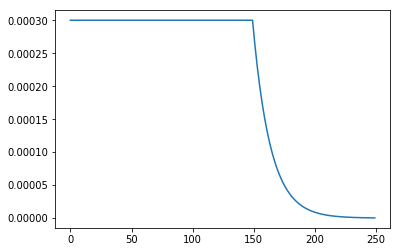

In [13]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [14]:
history = model.fit({}, EPOCHS, STEPS_PER_EPOCH,
                    val_dict=None, log_path=model_path if SAVE else None, 
                    call_step=50)

Epoch 1/250
 - 72s - loss: 21.0662
Epoch 2/250
 - 59s - loss: 12.3659
Epoch 3/250
 - 59s - loss: 2.1333
Epoch 4/250
 - 59s - loss: 1.1712
Epoch 5/250
 - 59s - loss: 0.9355
Epoch 6/250
 - 59s - loss: 0.8112
Epoch 7/250
 - 59s - loss: 0.8034
Epoch 8/250
 - 59s - loss: 0.7291
Epoch 9/250
 - 59s - loss: 0.6915
Epoch 10/250
 - 59s - loss: 0.6474
Epoch 11/250
 - 59s - loss: 0.6485
Epoch 12/250
 - 59s - loss: 0.6179
Epoch 13/250
 - 59s - loss: 0.6177
Epoch 14/250
 - 59s - loss: 0.6796
Epoch 15/250
 - 59s - loss: 0.7193
Epoch 16/250
 - 58s - loss: 0.7173
Epoch 17/250
 - 59s - loss: 0.6560
Epoch 18/250
 - 59s - loss: 0.6630
Epoch 19/250
 - 59s - loss: 0.6738
Epoch 20/250
 - 59s - loss: 0.6296
Epoch 21/250
 - 60s - loss: 0.7914
Epoch 22/250
 - 59s - loss: 0.6977
Epoch 23/250
 - 59s - loss: 0.6525
Epoch 24/250
 - 59s - loss: 0.6769
Epoch 25/250
 - 59s - loss: 0.6943
Epoch 26/250
 - 60s - loss: 0.6583
Epoch 27/250
 - 60s - loss: 0.6783
Epoch 28/250
 - 59s - loss: 0.5862
Epoch 29/250
 - 59s - loss:

KeyboardInterrupt: 

## Evaluation

### Baseline

In [ ]:
assert NUM_BRANCHES == 1

model_id_list = [1]
baseline_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc = baseline_one_shot(sess, model_name='model_'+str(model_id))
        print('Model {} acc:'.format(model_id), acc)
        baseline_acc_list.append(acc)
        
print('Mean acc:', np.mean(baseline_acc_list), ', std:', np.std(baseline_acc_list))

### Virtual Branching

In [8]:
model_id_list = [1]
vbranch_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
                                            NUM_BRANCHES, SHARED_FRAC, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)    
        acc, branch_acc = vbranch_one_shot(sess, model_name='model_'+str(model_id), 
                                           n_branches=NUM_BRANCHES)
        print('Model {} acc:'.format(model_id), acc, branch_acc)
        vbranch_acc_list.append(acc)
        
print('Mean acc:', np.mean(vbranch_acc_list), ', std:', np.std(vbranch_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/vb-omniglot-res-B2-S0.25_1/ckpt
Model 1 acc: 0.8375 [0.7849999999999999, 0.8125]
Mean acc: 0.8375 , std: 0.0
